<a href="https://colab.research.google.com/github/insyspo/match_local_global_ORI/blob/main/STI_2025_institutions_disambiguation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bigquery --project=insyspo

CREATE OR REPLACE TABLE projectdb_lattes.ies AS (
  SELECT  DISTINCT CD_ENTIDADE_CAPES AS id,
    SG_ENTIDADE_ENSINO AS sigla,
    NM_ENTIDADE_ENSINO AS nome
  FROM `insyspo.publicdb_capes_ppg.ies`
);

In [ ]:
%%bigquery --project=insyspo

SELECT b.CD_ENTIDADE_CAPES AS id_ies,
  a.CD_PROGRAMA_IES AS id_programa,
  c.SG_ENTIDADE_ENSINO AS sigla,
  c.NM_ENTIDADE_ENSINO AS nome,
  a.DOI
FROM `insyspo.publicdb_capes_ppg.ppg_doi` AS a
JOIN `insyspo.publicdb_capes_ppg.ppg` AS b
ON a.CD_PROGRAMA_IES = b.CD_PROGRAMA_IES
JOIN `insyspo.publicdb_capes_ppg.ies` AS c
ON c.CD_ENTIDADE_CAPES = b.CD_ENTIDADE_CAPES;


In [ ]:
%%bigquery --project=insyspo

SELECT *
FROM projectdb_lattes.ies
LIMIT 100

Query is running:   0%|          |

Downloading:   0%|          |

,id,sigla,nome
0,10001018,UNIR,UNIVERSIDADE FEDERAL DE RONDÔNIA
1,11001011,UFAC,UNIVERSIDADE FEDERAL DO ACRE
2,11008008,FIOCRUZ-RO,FIOCRUZ ( RONDÔNIA )
3,12001015,UFAM,UNIVERSIDADE FEDERAL DO AMAZONAS
4,12002011,INPA,INSTITUTO NACIONAL DE PESQUISAS DA AMAZÔNIA
...,...,...,...
95,25016016,FJN,FUNDACAO JOAQUIM NABUCO
96,25017012,ITEP,ASSOCIAÇÃO INSTITUTO DE TECNOLOGIA DE PERNAMBUCO
97,25018019,FBV,FACULDADE BOA VIAGEM
98,25018019,UNIFBV-WYDEN,CENTRO UNIVERSITÁRIO FBV WYDEN


In [ ]:
%%bigquery --project=insyspo

CREATE OR REPLACE TABLE projectdb_lattes.ies AS (
  SELECT  DISTINCT CD_ENTIDADE_CAPES AS id,
    SG_ENTIDADE_ENSINO AS sigla,
    NM_ENTIDADE_ENSINO AS nome
  FROM `insyspo.publicdb_capes_ppg.ies` AS a
);

In [ ]:
%%bigquery --project=insyspo

CREATE OR REPLACE TABLE projectdb_lattes.dois_ies AS (
  SELECT  DISTINCT a.CD_ENTIDADE_CAPES, b.DOI
  FROM `insyspo.publicdb_capes_ppg.ppg` AS a
  JOIN `insyspo.publicdb_capes_ppg.ppg_doi` AS b
  ON a.CD_PROGRAMA_IES = b.CD_PROGRAMA_IES
  WHERE LENGTH(b.DOI)>4
);

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project=insyspo
SELECT *
FROM projectdb_lattes.dois_ies

Query is running:   0%|          |

Downloading:   0%|          |

,CD_ENTIDADE_CAPES,DOI
0,10001018,10.26220/aca.2837
1,10001018,10.1093/mnras/stx2240
2,10001018,10.31072/rcf.v9i1.561
3,10001018,10.4000/confins.12315
4,10001018,10.25186/cs.v12i2.1228
...,...,...
590092,53069005,10.22187/rfd2020n49a17
590093,53069005,10.5902/1981369437281
590094,53069005,10.34280/annep/2020.v1i1.9
590095,53069005,10.5020/2317-2150.2020.10139


In [ ]:
%%bigquery --project=insyspo

CREATE OR REPLACE TABLE projectdb_lattes.dois_ies_oa AS (
  SELECT a.id, a.doi, b.CD_ENTIDADE_CAPES
  FROM publicdb_openalex_2025_03_rm.works AS a
  JOIN projectdb_lattes.dois_ies AS b
  ON a.doi = b.DOI
);

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project=insyspo

CREATE OR REPLACE TABLE projectdb_lattes.ies_ioa_ndois AS (
  SELECT a.CD_ENTIDADE_CAPES, b.institution_id,
    COUNT(DISTINCT(id)) AS works
  FROM projectdb_lattes.dois_ies_oa AS a
  JOIN publicdb_openalex_2025_03_rm.works_authorships AS b
  ON a.id = b.work_id
  GROUP BY a.CD_ENTIDADE_CAPES, b.institution_id
  #ORDER BY CD_ENTIDADE_CAPES, works DESC
);

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project=insyspo

CREATE OR REPLACE TABLE projectdb_lattes.ies_ioa_candidate_match AS (
  SELECT CD_ENTIDADE_CAPES, institution_id,
    works,
    ROW_NUMBER() OVER (
      PARTITION BY CD_ENTIDADE_CAPES
      ORDER BY works DESC
      ) AS r
    FROM projectdb_lattes.ies_ioa_ndois
)

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project=insyspo

CREATE OR REPLACE TABLE projectdb_lattes.ies_ioa_candidate_match_names AS (
  SELECT a.*,
    b.display_name_alternatives,
    REGEXP_REPLACE(d.display_name_acronyms,r'[^A-Za-z]','') AS display_name_acronyms,
    REGEXP_REPLACE(c.sigla,r'[^A-Za-z]','') AS sigla,
    c.nome,
  FROM projectdb_lattes.ies_ioa_candidate_match AS a
  JOIN ( # combine display name alternatives with main name in the institutions' table
    SELECT a.id AS institution_id,
        b.display_name_alternatives,
        a.ror
    FROM `insyspo.publicdb_openalex_2025_03_rm.institutions` AS a
    JOIN `insyspo.publicdb_openalex_2025_03_rm.institutions_display_name_alternatives` AS b
    ON a.id = b.institution_id
    UNION ALL
    SELECT id AS institution_id,
      display_name AS display_name_alternatives,
      ror
    FROM `insyspo.publicdb_openalex_2025_03_rm.institutions`
  ) AS b
  ON a.institution_id = b.institution_id
  JOIN projectdb_lattes.ies AS c
  ON a.CD_ENTIDADE_CAPES = c.id
  JOIN publicdb_openalex_2025_03_rm.institutions_display_name_acronyms AS d
  ON a.institution_id = d.institution_id
  ORDER BY CD_ENTIDADE_CAPES, r
)

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project=insyspo

CREATE OR REPLACE TABLE projectdb_lattes.ies_ioa_candidate_match_names_seq AS (
WITH aux AS (
  SELECT *,
    IF(LOWER(display_name_acronyms) LIKE CONCAT('%',LOWER(sigla),'%')
        OR LOWER(sigla) LIKE CONCAT('%',LOWER(display_name_acronyms),'%'),0,
      EDIT_DISTANCE(LOWER(display_name_acronyms),LOWER(sigla))) AS d_sigla,
    EDIT_DISTANCE(LOWER(display_name_alternatives),LOWER(nome)) AS d_nome,
  FROM projectdb_lattes.ies_ioa_candidate_match_names
  WHERE r<10 AND works>10
)
SELECT
  *,
   ROW_NUMBER() OVER (
      PARTITION BY CD_ENTIDADE_CAPES
      ORDER BY d_sigla, r, d_nome
      ) AS seq
FROM aux
WHERE d_sigla < 5
)


Query is running:   0%|          |

""


In [ ]:
%%bigquery --project=insyspo

CREATE OR REPLACE TABLE projectdb_lattes.ies_ioa_candidate_match_names_seq_1 AS (
  SELECT *,
  FROM projectdb_lattes.ies_ioa_candidate_match_names_seq
  WHERE seq = 1
);

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project=insyspo

SELECT CD_ENTIDADE_CAPES AS institution,
  COUNT(DISTINCT(institution_id)) AS merged
FROM projectdb_lattes.ies_ioa_candidate_match_names_seq_1
GROUP BY CD_ENTIDADE_CAPES
ORDER BY merged DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,institution,merged
0,31096018,1
1,31034012,1
2,53037014,1
3,31009018,1
4,31022014,1
...,...,...
383,15027007,1
384,31073018,1
385,28008014,1
386,42014018,1


In [ ]:
%%bigquery --project=insyspo
  SELECT institution_id, COUNT(DISTINCT(DIV(CD_ENTIDADE_CAPES,100))) AS ncapes # exclude last two digits that are different departments
  FROM projectdb_lattes.ies_ioa_candidate_match_names_seq_1
  GROUP BY institution_id
  #HAVING ncapes>1
  ORDER BY ncapes DESC

Query is running:   0%|          |

Downloading:   0%|          |

,institution_id,ncapes
0,17974374,14
1,52325,7
2,44202434,7
3,110200422,5
4,161127581,4
...,...,...
280,52357470,1
281,4210145809,1
282,4210145983,1
283,4210162743,1


In [ ]:
%%bigquery --project=insyspo

SELECT ncapes AS merged,
COUNT(*) AS institutions
FROM (
  SELECT institution_id, COUNT(DISTINCT(DIV(CD_ENTIDADE_CAPES,100))) AS ncapes # exclude last two digits that are different departments
  FROM projectdb_lattes.ies_ioa_candidate_match_names_seq_1
  GROUP BY institution_id
  #HAVING ncapes>1
  ORDER BY ncapes DESC
) GROUP BY merged
ORDER BY institutions DESC

Query is running:   0%|          |

Downloading:   0%|          |

,merged,institutions
0,1,250
1,2,19
2,3,10
3,7,2
4,4,2
5,5,1
6,14,1


In [ ]:
%%bigquery institutions_errors --project=insyspo


SELECT a.id, a.nome, c.institution_id, d.display_name
FROM projectdb_lattes.ies AS a
JOIN projectdb_lattes.ies_ioa_candidate_match_names_seq_1 AS b
ON a.id = b.CD_ENTIDADE_CAPES
JOIN (
  SELECT institution_id, COUNT(DISTINCT(DIV(CD_ENTIDADE_CAPES,100))) AS ncapes
  FROM projectdb_lattes.ies_ioa_candidate_match_names_seq_1
  GROUP BY institution_id
  HAVING ncapes > 1
) AS c
ON b.institution_id = c.institution_id
JOIN publicdb_openalex_2025_03_rm.institutions AS d
ON d.id = c.institution_id
ORDER BY institution_id

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
institutions_errors.to_csv('institutions_errors.csv')

In [ ]:
%%bigquery --project=insyspo

SELECT a.*
FROM projectdb_lattes.ies_ioa_candidate_match_names_seq AS a
LEFT JOIN projectdb_lattes.ies_ioa_candidate_match_names_seq_1 AS b
ON a.CD_ENTIDADE_CAPES = b.CD_ENTIDADE_CAPES
WHERE b.CD_ENTIDADE_CAPES IS NULL
ORDER BY a.CD_ENTIDADE_CAPES, seq;

Query is running:   0%|          |

Downloading: |          |

,CD_ENTIDADE_CAPES,institution_id,works,r,display_name_alternatives,display_name_acronyms,sigla,nome,d_sigla,d_nome,seq


In [ ]:
%%bigquery --project=insyspo

# table to get possible name variations for institutions from ROR
CREATE OR REPLACE TABLE projectdb_lattes.ror_aliases AS (
  SELECT id AS ror, nome, TRIM(sigla_) sigla # ROR, name and acronym
  FROM (
    SELECT a.id, a.nome,
      SPLIT(b.acronyms,';') AS siglas # acronyms' variations
    FROM (
        SELECT id, TRIM(SUBSTR(label_, 4)) AS nome # languages variations
        FROM (
          SELECT id, SPLIT(labels,'; ') AS labels_
          FROM projectdb_lattes.ror_data
          WHERE country_country_code = 'BR'
        ), UNNEST(labels_) label_
        UNION ALL
        SELECT id, name AS nome # main name
        FROM projectdb_lattes.ror_data
        WHERE country_country_code = 'BR'
        UNION ALL
        SELECT id, TRIM(nome_) AS nome # other aliases
        FROM (
          SELECT id,
            SPLIT(aliases,';') AS aliases,
          FROM projectdb_lattes.ror_data
          WHERE country_country_code = 'BR'
        ), UNNEST(aliases) nome_
    ) AS a
    JOIN projectdb_lattes.ror_data AS b
    ON a.id = b.id
  ), UNNEST(siglas) sigla_
);

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project=insyspo

CREATE OR REPLACE TABLE projectdb_lattes.oa_ror_aliases AS (
  SELECT  b.id AS institution_id,
    a.*
  FROM projectdb_lattes.ror_aliases AS a
  LEFT JOIN publicdb_openalex_2025_03_rm.institutions AS b
  ON a.ror = b.ror
);

Query is running:   0%|          |

""


# Checking ROR registry against OpenAlex's institutional table.

In [ ]:
%%bigquery --project=insyspo

SELECT id, ror,
  COUNT(DISTINCT(name)) AS names,
  COUNT(DISTINCT(nome)) AS nomes
FROM (
  SELECT a.id, a.name, c.ror, c.nome, c.sigla
  FROM (
    SELECT a.id, b.display_name_alternatives AS name,
      a.ror
    FROM `insyspo.publicdb_openalex_2025_03_rm.institutions` AS a
    JOIN `insyspo.publicdb_openalex_2025_03_rm.institutions_display_name_alternatives` AS b
    ON a.id = b.institution_id
    UNION ALL
    SELECT id, display_name AS name,
      ror
    FROM `insyspo.publicdb_openalex_2025_03_rm.institutions`
  ) AS a
  RIGHT JOIN `insyspo.projectdb_lattes.ror_aliases` AS c
  ON a.ror = c.ror
  WHERE a.id IS NOT NULL
  ORDER BY c.ror, a.id
)
GROUP BY id, ror
HAVING names != nomes

In [ ]:
%%bigquery --project=insyspo

SELECT *
FROM (
    SELECT a.id, b.display_name_alternatives AS name,
      a.ror
    FROM `insyspo.publicdb_openalex_2025_03_rm.institutions` AS a
    JOIN `insyspo.publicdb_openalex_2025_03_rm.institutions_display_name_alternatives` AS b
    ON a.id = b.institution_id
    UNION ALL
    SELECT id, display_name AS name,
      ror
    FROM `insyspo.publicdb_openalex_2025_03_rm.institutions`
  )
  WHERE id IN (4210149451,52325,4210095538,47403697,3017928408)
  ORDER BY id

# Analysing data after manual check

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

source = r'/content/drive/MyDrive/Projeto Lattes Mobilidade/Tabelas/institutions_errors-completed.csv'

df = pd.read_csv(source)

array_id_error = df[(df['Erro?'] == True)]['id'].unique()
list_id_error = list(array_id_error)

df_id_error = pd.DataFrame({'id':list_id_error})
df_id_error

,id
0,33147019
1,41012011
2,28008014
3,33008019
4,33024014
5,33028010
6,33073015
7,33114013
8,33120013
9,33129010


In [ ]:
project_id = 'insyspo'
table_id = 'projectdb_lattes.ies_ioa_error'

df_id_error.to_gbq(table_id, project_id=project_id)

<ipython-input-24-6c54e199512c>:4: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df_id_error.to_gbq(table_id, project_id=project_id)
100%|██████████| 1/1 [00:00<00:00, 5584.96it/s]


In [ ]:
%%bigquery correct_institutions--project=insyspo

SELECT DISTINCT(CD_ENTIDADE_CAPES)
FROM projectdb_lattes.ies_ioa_candidate_match_names_seq_1
FULL OUTER JOIN `projectdb_lattes.ies_ioa_error` AS b
ON CD_ENTIDADE_CAPES = b.id
WHERE b.id IS NULL
;

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
correct_institutions

,CD_ENTIDADE_CAPES
0,31050018
1,33004102
2,52012018
3,32057016
4,32016018
...,...
328,21001014
329,33076014
330,28007018
331,28022017


In [ ]:
project_id = 'insyspo'
table_id = 'projectdb_lattes.ies_ioa_correct'

correct_institutions.to_gbq(table_id, project_id=project_id)

<ipython-input-40-b60cea612c26>:4: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  correct_institutions.to_gbq(table_id, project_id=project_id)
100%|██████████| 1/1 [00:00<00:00, 2056.03it/s]


# Graph generation

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_gbq

In [ ]:
%%bigquery df --project = insyspo

SELECT *
FROM projectdb_lattes.ies_ioa_ndois
#WHERE works > 10
ORDER BY works DESC
LIMIT 1000

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df.head()

,CD_ENTIDADE_CAPES,institution_id,works
0,33002010,17974374,22235
1,42001013,130442723,13803
2,31001017,122140584,12891
3,33003017,181391015,12847
4,32001010,110200422,12528


Text(0, 0.5, 'Number of institutions matched')

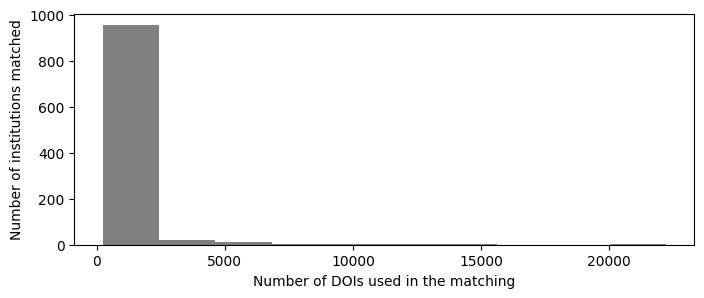

In [ ]:
plt.figure(figsize=(8,3))
#xd = np.arange(0,7000)+1
plt.hist(df['works'],color = "gray")
#plt.xticks(xd)
plt.xlabel('Number of DOIs used in the matching')
plt.ylabel('Number of institutions matched')

In [ ]:
%%bigquery df --project = insyspo

SELECT b.CD_ENTIDADE_CAPES, COUNT(DISTINCT(CD_PROGRAMA_IES)) AS n_ppg
FROM publicdb_capes_ppg.ppg AS a
JOIN `insyspo.projectdb_lattes.ies_ioa_correct` AS b
ON a.CD_ENTIDADE_CAPES = b.CD_ENTIDADE_CAPES
GROUP BY CD_ENTIDADE_CAPES
ORDER BY n_ppg DESC;

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df.head(40)

,CD_ENTIDADE_CAPES,n_ppg
0,33002010,180
1,31001017,125
2,53001010,97
3,42001013,96
4,15001016,90
5,32001010,87
6,23001011,86
7,25001019,86
8,28001010,85
9,41001010,81


In [ ]:
%%bigquery df --project = insyspo

SELECT b.id, COUNT(DISTINCT(CD_PROGRAMA_IES)) AS n_ppg
FROM publicdb_capes_ppg.ppg AS a
JOIN `insyspo.projectdb_lattes.ies_ioa_error` AS b
ON a.CD_ENTIDADE_CAPES = b.id
GROUP BY b.id
ORDER BY n_ppg DESC;


Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df

,id,n_ppg
0,31005012,35
1,32011016,20
2,33024014,15
3,31033016,14
4,33092010,14
5,52059006,11
6,30011019,7
7,33107017,7
8,33082014,6
9,42014018,6


In [ ]:
%%bigquery total_wrong_institutions --project = insyspo

SELECT COUNT(DISTINCT(id)) AS total_wrong_institutions
FROM `insyspo.projectdb_lattes.ies_ioa_error`


Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
%%bigquery total_correct_institutions --project = insyspo

SELECT COUNT(DISTINCT(CD_ENTIDADE_CAPES)) AS total_correct_institutions
FROM `insyspo.projectdb_lattes.ies_ioa_correct`

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
total_correct_institutions

,total_correct_institutions
0,333


In [ ]:
import pandas as pd
import matplotlib as plt

df = pd.DataFrame()
df['Misclassified'] = total_wrong_institutions
df['Correctly classified'] = total_correct_institutions

df.index = ['Status of classification']

df

,Misclassified,Correctly classified
Status of classification,55,333


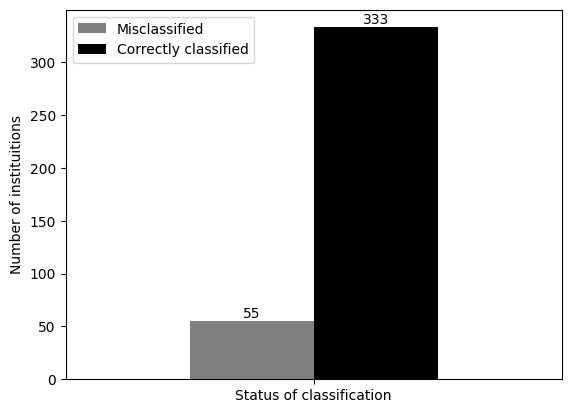

In [ ]:
ax = df.plot.bar(color=['gray', 'black'], ylabel='Number of instituitions')

ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2,
        p.get_height() + 3,
        f'{p.get_height():.0f}',
        ha='center'
    )


In [ ]:
%%bigquery total_wrong_ppg --project = insyspo

SELECT SUM(n_ppg) AS total_wrong_ppg
FROM (
  SELECT CD_ENTIDADE_CAPES, COUNT(DISTINCT(CD_PROGRAMA_IES)) AS n_ppg
  FROM `insyspo.publicdb_capes_ppg.ppg`
  WHERE DS_SITUACAO_PROGRAMA = "EM FUNCIONAMENTO"
  GROUP BY CD_ENTIDADE_CAPES
  ) AS a
JOIN `insyspo.projectdb_lattes.ies_ioa_error` AS B
ON a.CD_ENTIDADE_CAPES = b.id

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
%%bigquery total_correct_ppg --project = insyspo

SELECT SUM(n_ppg) AS total_correct_ppg
FROM (
  SELECT CD_ENTIDADE_CAPES, COUNT(DISTINCT(CD_PROGRAMA_IES)) AS n_ppg
  FROM `insyspo.publicdb_capes_ppg.ppg`
  WHERE DS_SITUACAO_PROGRAMA = "EM FUNCIONAMENTO"
  GROUP BY CD_ENTIDADE_CAPES
  ) AS a
JOIN `insyspo.projectdb_lattes.ies_ioa_correct` AS B
ON a.CD_ENTIDADE_CAPES = b.CD_ENTIDADE_CAPES

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
import pandas as pd
import matplotlib as plt

df = pd.DataFrame()
df['Misclassified'] = total_wrong_ppg
df['Correctly classified'] = total_correct_ppg

df.index = ['Status of classification of the institution']

df

,Misclassified,Correctly classified
Status of classification of the institution,228,4422


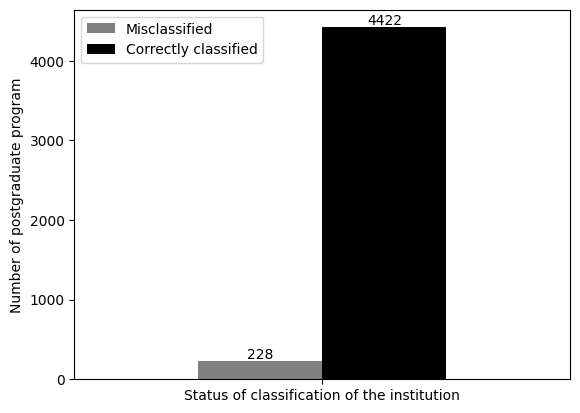

In [ ]:
ax = df.plot.bar(color=['gray', 'black'], ylabel='Number of postgraduate program')

ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2,
        p.get_height() + 30,
        f'{p.get_height():.0f}',
        ha='center'
    )


In [ ]:
%%bigquery wrong_ppg --project = insyspo

SELECT a.CD_ENTIDADE_CAPES,
  AVG(a.n_ppg) AS n_ppg,
  ANY_VALUE(c.NM_ENTIDADE_ENSINO) AS nome,
  ANY_VALUE(c.CS_STATUS_JURIDICO) AS status_juridico,
  ANY_VALUE(c.DS_DEPENDENCIA_ADMINISTRATIVA) AS dependencia_administrativa
FROM (
  SELECT CD_ENTIDADE_CAPES, COUNT(DISTINCT(CD_PROGRAMA_IES)) AS n_ppg
  FROM `insyspo.publicdb_capes_ppg.ppg`
  WHERE DS_SITUACAO_PROGRAMA = "EM FUNCIONAMENTO"
  GROUP BY CD_ENTIDADE_CAPES
  ) AS a
JOIN `insyspo.projectdb_lattes.ies_ioa_error` AS b
ON a.CD_ENTIDADE_CAPES = b.id
JOIN `insyspo.publicdb_capes_ppg.ies` AS c
ON a.CD_ENTIDADE_CAPES = c.CD_ENTIDADE_CAPES
GROUP BY CD_ENTIDADE_CAPES
ORDER BY n_ppg  DESC, status_juridico ASC


Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
%%bigquery wrong_ppg --project = insyspo

SELECT a.CD_ENTIDADE_CAPES,
  AVG(a.n_ppg) AS n_ppg,
  ANY_VALUE(c.NM_ENTIDADE_ENSINO) AS nome,
  ANY_VALUE(c.CS_STATUS_JURIDICO) AS status_juridico,
  ANY_VALUE(c.DS_DEPENDENCIA_ADMINISTRATIVA) AS dependencia_administrativa,
  MAX(n_DOI) AS n_DOI,
  MAX(total_citations) AS total_citations,
  MAX(average_citations) AS average_citations,
FROM (
  SELECT CD_ENTIDADE_CAPES, COUNT(DISTINCT(CD_PROGRAMA_IES)) AS n_ppg
  FROM `insyspo.publicdb_capes_ppg.ppg`
  WHERE DS_SITUACAO_PROGRAMA = "EM FUNCIONAMENTO"
  GROUP BY CD_ENTIDADE_CAPES
  ) AS a
JOIN `insyspo.projectdb_lattes.ies_ioa_error` AS b
ON a.CD_ENTIDADE_CAPES = b.id
JOIN `insyspo.publicdb_capes_ppg.ies` AS c
ON a.CD_ENTIDADE_CAPES = c.CD_ENTIDADE_CAPES
JOIN (
  SELECT CD_ENTIDADE_CAPES,
    COUNT(DISTINCT(DOI)) AS n_DOI,
    SUM(cited_by_count) AS total_citations,
    AVG(cited_by_count) AS average_citations,
  FROM (
    SELECT *
    FROM (
      SELECT c.CD_ENTIDADE_CAPES, c.DOI, d.cited_by_count
      FROM `insyspo.projectdb_lattes.dois_ies` AS c
      JOIN `insyspo.publicdb_openalex_2025_03_rm.works` AS d
      ON c.DOI = d.doi
      ) AS a
    JOIN `insyspo.projectdb_lattes.ies_ioa_error` AS b
    ON a.CD_ENTIDADE_CAPES = b.id
    )
  GROUP BY CD_ENTIDADE_CAPES
  ) AS d
ON a.CD_ENTIDADE_CAPES = d.CD_ENTIDADE_CAPES
GROUP BY CD_ENTIDADE_CAPES
ORDER BY total_citations DESC, status_juridico ASC


Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
#wrong_ppg = wrong_ppg.drop_duplicates()

wrong_ppg

,CD_ENTIDADE_CAPES,n_ppg,nome,status_juridico,dependencia_administrativa,n_DOI,total_citations,average_citations
0,31005012,34.0,PONTIFÍCIA UNIVERSIDADE CATÓLICA DO RIO DE JAN...,PARTICULAR,PRIVADA,3066,56019,18.271037
1,31033016,14.0,UNIVERSIDADE ESTADUAL DO NORTE FLUMINENSE DARC...,ESTADUAL,PÚBLICA,1626,29564,18.182042
2,32011016,20.0,UNIVERSIDADE FEDERAL DE ALFENAS,FEDERAL,PÚBLICA,1545,24863,16.092557
3,33092010,14.0,UNIVERSIDADE NOVE DE JULHO,PARTICULAR,PRIVADA,1485,22618,15.230976
4,33073015,2.0,FUNDAÇÃO ANTONIO PRUDENTE - HOSPITAL A. C. CAM...,PARTICULAR,PRIVADA,603,17919,29.716418
5,33160015,2.0,INSTITUTO SÍRIO-LIBANÊS DE ENSINO E PESQUISA,PARTICULAR,PRIVADA,458,16848,36.786026
6,33147019,1.0,SOCIEDADE BRASILEIRA DE FISIOLOGIA,PARTICULAR,PRIVADA,723,14984,20.724758
7,33283010,1.0,SOCIEDADE BRASILEIRA DE FÍSICA,PARTICULAR,PRIVADA,1378,14597,10.592888
8,33024014,15.0,UNIVERSIDADE PRESBITERIANA MACKENZIE,PARTICULAR,PRIVADA,959,13922,14.517205
9,15027007,3.0,MUSEU PARAENSE EMÍLIO GOELDI,FEDERAL,PÚBLICA,459,13361,29.108932


In [ ]:
sum(wrong_ppg['total_citations'])

np.int64(351541)

In [ ]:
%%bigquery mesures_wrong --project = insyspo

SELECT
  COUNT(DISTINCT(DOI)) AS total_doi,
  AVG(total_citations) AS avarage_citations,
  SUM(total_citations) AS total_citations
FROM (
  SELECT DISTINCT(DOI) AS DOI,
   SUM(cited_by_count) AS total_citations
  FROM (
    SELECT *
    FROM (
      SELECT c.CD_ENTIDADE_CAPES, c.DOI, d.cited_by_count
      FROM `insyspo.projectdb_lattes.dois_ies` AS c
      JOIN `insyspo.publicdb_openalex_2025_03_rm.works` AS d
      ON c.DOI = d.doi
      ) AS a
    JOIN `insyspo.projectdb_lattes.ies_ioa_error` AS b
    ON a.CD_ENTIDADE_CAPES = b.id
    )
  GROUP BY DOI
  )


Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
mesures_wrong

,total_doi,avarange_citations,total_citations
0,21054,16.697112,351541


In [ ]:
%%bigquery wrong_areas --project = insyspo

SELECT c.NM_GRANDE_AREA,
  COUNT(NM_GRANDE_AREA) AS n
FROM (
  SELECT CD_ENTIDADE_CAPES, CD_AREA_AVALIACAO
  FROM `insyspo.publicdb_capes_ppg.ppg`
  WHERE DS_SITUACAO_PROGRAMA = "EM FUNCIONAMENTO"
  ) AS a
JOIN `insyspo.projectdb_lattes.ies_ioa_error` AS b
ON a.CD_ENTIDADE_CAPES = b.id
JOIN `insyspo.publicdb_capes_ppg.areas` AS c
ON a.CD_AREA_AVALIACAO = c.CD_AREA_AVALIACAO
GROUP BY NM_GRANDE_AREA
ORDER BY n DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
%%bigquery correct_areas --project = insyspo

SELECT c.NM_GRANDE_AREA,
  COUNT(NM_GRANDE_AREA) AS n
FROM (
  SELECT CD_ENTIDADE_CAPES, CD_AREA_AVALIACAO
  FROM `insyspo.publicdb_capes_ppg.ppg`
  WHERE DS_SITUACAO_PROGRAMA = "EM FUNCIONAMENTO"
  ) AS a
JOIN `insyspo.projectdb_lattes.ies_ioa_correct` AS b
ON a.CD_ENTIDADE_CAPES = b.CD_ENTIDADE_CAPES
JOIN `insyspo.publicdb_capes_ppg.areas` AS c
ON a.CD_AREA_AVALIACAO = c.CD_AREA_AVALIACAO
GROUP BY NM_GRANDE_AREA
ORDER BY n DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
wrong_areas

,NM_GRANDE_AREA,n
0,Ciências Humanas,339
1,Multidisciplinar,337
2,Ciências da Saúde,251
3,Ciências Sociais Aplicadas,195
4,Engenharias,175
5,Ciências Exatas e da Terra,101
6,Ciências Biológicas,96
7,Ciências Agrárias,92
8,"Linguística, Letras e Artes",37


In [ ]:
correct_areas

,NM_GRANDE_AREA,n
0,Ciências Humanas,6017
1,Ciências da Saúde,5547
2,Multidisciplinar,5420
3,Ciências Agrárias,3518
4,Engenharias,3471
5,Ciências Sociais Aplicadas,3365
6,Ciências Exatas e da Terra,2787
7,Ciências Biológicas,2625
8,"Linguística, Letras e Artes",1764


In [ ]:
data_correct = correct_areas[['n']](normalize=True).reset_index(name='Correctly classified')

data_correct

SyntaxError: invalid syntax (<ipython-input-219-503cbbddb391>, line 1)

In [ ]:
#data_correct = correct_areas[['NM_GRANDE_AREA']].value_counts(normalize=True).reset_index(name='Correctly classified')

#data_wrong = wrong_areas[['NM_GRANDE_AREA']].value_counts(normalize=True).reset_index(name='Misclassified')

merged = wrong_areas.merge(correct_areas, on='NM_GRANDE_AREA', how='left')

merged = merged.rename(columns={'NM_GRANDE_AREA': 'Program field', 'n_x': 'Misclassified institution', 'n_y': 'Correctly classified institution'})

sum_correct = sum(merged['Correctly classified institution'])
sum_wrong = sum(merged['Misclassified institution'])

merged['Correctly classified institution'] = merged['Correctly classified institution']*100.0/sum_correct
merged['Misclassified institution'] = merged['Misclassified institution']*100.0/sum_wrong

merged


,Program field,Misclassified institution,Correctly classified institution
0,Ciências Humanas,20.887246,17.433505
1,Multidisciplinar,20.764017,15.703772
2,Ciências da Saúde,15.465188,16.071739
3,Ciências Sociais Aplicadas,12.014787,9.749667
4,Engenharias,10.782502,10.056789
5,Ciências Exatas e da Terra,6.223044,8.074984
6,Ciências Biológicas,5.914972,7.605609
7,Ciências Agrárias,5.668515,10.192965
8,"Linguística, Letras e Artes",2.279729,5.110969


In [ ]:
merged.iloc[0,0] = 'Humanities'
merged.iloc[1,0] = 'Multidisciplinary'
merged.iloc[2,0] = 'Health Sciences'
merged.iloc[3,0] = 'Applied Social Sciences'
merged.iloc[4,0] = 'Engineering'
merged.iloc[5,0] = 'Exact and Earth Sciences'
merged.iloc[6,0] = 'Biological Sciences'
merged.iloc[7,0] = 'Agricultural Sciences'
merged.iloc[8,0] = 'Linguistics, Letters and Arts'

merged

,Program field,Misclassified institution,Correctly classified institution
0,Humanities,20.887246,17.433505
1,Multidisciplinary,20.764017,15.703772
2,Health Sciences,15.465188,16.071739
3,Applied Social Sciences,12.014787,9.749667
4,Engineering,10.782502,10.056789
5,Exact and Earth Sciences,6.223044,8.074984
6,Biological Sciences,5.914972,7.605609
7,Agricultural Sciences,5.668515,10.192965
8,"Linguistics, Letters and Arts",2.279729,5.110969


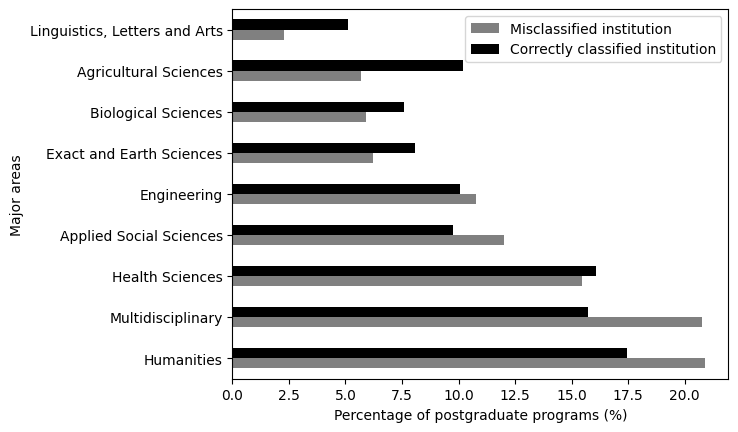

In [ ]:
ax = merged.plot.barh(color={'Correctly classified institution': 'black', 'Misclassified institution': 'gray'}, x='Program field', ylabel='Major areas', xlabel='Percentage of postgraduate programs (%)')